In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline
import joblib
import warnings
warnings.filterwarnings('ignore')


In [2]:
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

print("📊 LOAN APPROVAL PREDICTION MODEL")
print("=" * 50)
print("\n1️⃣ LOADING AND EXPLORING DATA")
print("-" * 30)
df = pd.read_csv('loan_approval_dataset.csv')

📊 LOAN APPROVAL PREDICTION MODEL

1️⃣ LOADING AND EXPLORING DATA
------------------------------


In [3]:
df.columns = df.columns.str.strip()

print(f"Dataset shape: {df.shape}")
print(f"Columns: {list(df.columns)}")

Dataset shape: (4269, 13)
Columns: ['loan_id', 'no_of_dependents', 'education', 'self_employed', 'income_annum', 'loan_amount', 'loan_term', 'cibil_score', 'residential_assets_value', 'commercial_assets_value', 'luxury_assets_value', 'bank_asset_value', 'loan_status']


In [4]:
print("\n📈 Dataset Info:")
print(df.info())

print("\n📋 First 5 rows:")
print(df.head())

print("\n🎯 Target variable distribution:")
print(df['loan_status'].value_counts())
print(f"Approval rate: {(df['loan_status'] == 'Approved').mean():.2%}")


📈 Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4269 entries, 0 to 4268
Data columns (total 13 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   loan_id                   4269 non-null   int64 
 1   no_of_dependents          4269 non-null   int64 
 2   education                 4269 non-null   object
 3   self_employed             4269 non-null   object
 4   income_annum              4269 non-null   int64 
 5   loan_amount               4269 non-null   int64 
 6   loan_term                 4269 non-null   int64 
 7   cibil_score               4269 non-null   int64 
 8   residential_assets_value  4269 non-null   int64 
 9   commercial_assets_value   4269 non-null   int64 
 10  luxury_assets_value       4269 non-null   int64 
 11  bank_asset_value          4269 non-null   int64 
 12  loan_status               4269 non-null   object
dtypes: int64(10), object(3)
memory usage: 433.7+ KB
None

📋 First

In [5]:
print("\n🔍 Missing values:")
missing_values = df.isnull().sum()
print(missing_values[missing_values > 0] if missing_values.sum() > 0 else "No missing values found!")



🔍 Missing values:
No missing values found!



2️⃣ EXPLORATORY DATA ANALYSIS
------------------------------


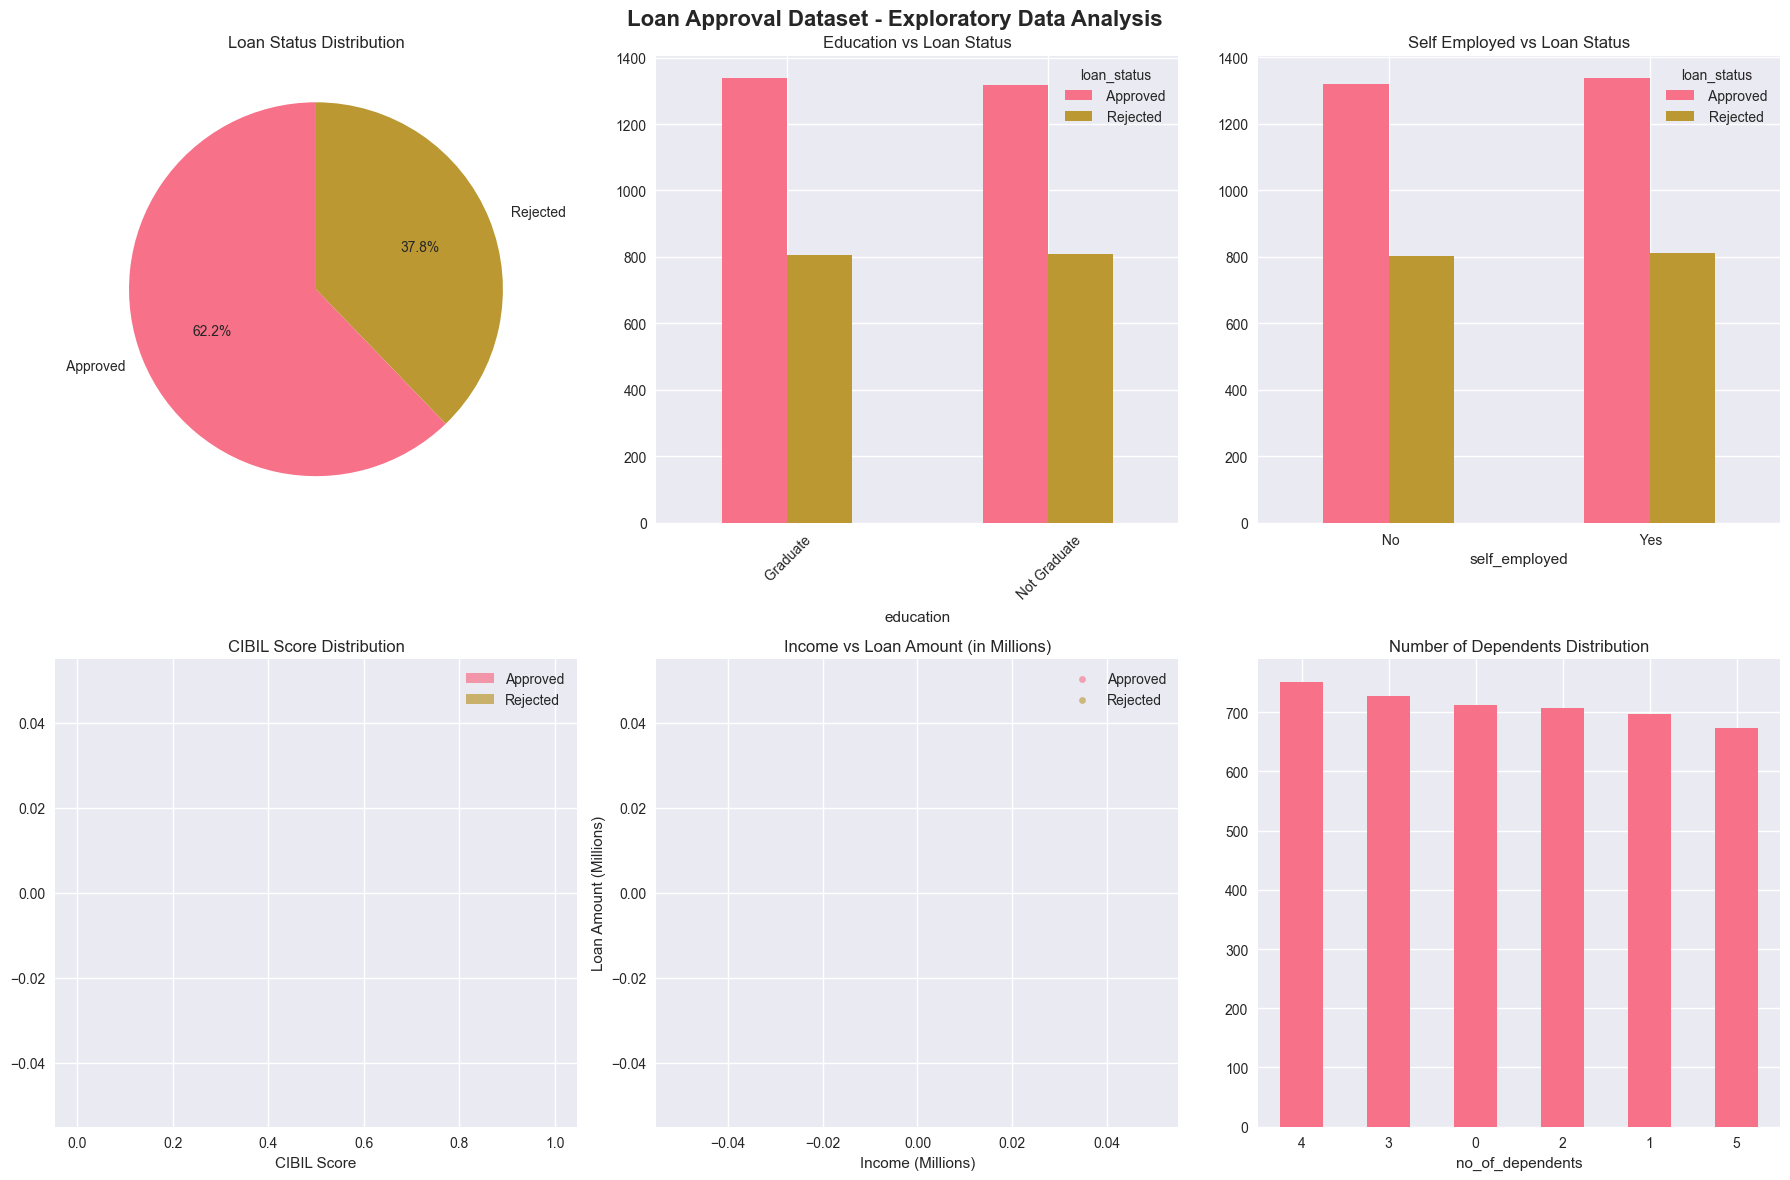

In [6]:
print("\n2️⃣ EXPLORATORY DATA ANALYSIS")
print("-" * 30)
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
fig.suptitle('Loan Approval Dataset - Exploratory Data Analysis', fontsize=16, fontweight='bold')
axes[0, 0].pie(df['loan_status'].value_counts().values, 
               labels=df['loan_status'].value_counts().index,
               autopct='%1.1f%%', startangle=90)
axes[0, 0].set_title('Loan Status Distribution')
pd.crosstab(df['education'], df['loan_status']).plot(kind='bar', ax=axes[0, 1])
axes[0, 1].set_title('Education vs Loan Status')
axes[0, 1].tick_params(axis='x', rotation=45)
pd.crosstab(df['self_employed'], df['loan_status']).plot(kind='bar', ax=axes[0, 2])
axes[0, 2].set_title('Self Employed vs Loan Status')
axes[0, 2].tick_params(axis='x', rotation=0)
axes[1, 0].hist([df[df['loan_status'] == 'Approved']['cibil_score'],
                 df[df['loan_status'] == 'Rejected']['cibil_score']],
                bins=30, alpha=0.7, label=['Approved', 'Rejected'])
axes[1, 0].set_title('CIBIL Score Distribution')
axes[1, 0].set_xlabel('CIBIL Score')
axes[1, 0].legend()
approved = df[df['loan_status'] == 'Approved']
rejected = df[df['loan_status'] == 'Rejected']
axes[1, 1].scatter(approved['income_annum']/1000000, approved['loan_amount']/1000000, 
                   alpha=0.6, label='Approved', s=20)
axes[1, 1].scatter(rejected['income_annum']/1000000, rejected['loan_amount']/1000000, 
                   alpha=0.6, label='Rejected', s=20)
axes[1, 1].set_title('Income vs Loan Amount (in Millions)')
axes[1, 1].set_xlabel('Income (Millions)')
axes[1, 1].set_ylabel('Loan Amount (Millions)')
axes[1, 1].legend()
df['no_of_dependents'].value_counts().plot(kind='bar', ax=axes[1, 2])
axes[1, 2].set_title('Number of Dependents Distribution')
axes[1, 2].tick_params(axis='x', rotation=0)

plt.tight_layout()
plt.show()



📊 Statistical Summary:
           loan_id  no_of_dependents  income_annum   loan_amount    loan_term  \
count  4269.000000       4269.000000  4.269000e+03  4.269000e+03  4269.000000   
mean   2135.000000          2.498712  5.059124e+06  1.513345e+07    10.900445   
std    1232.498479          1.695910  2.806840e+06  9.043363e+06     5.709187   
min       1.000000          0.000000  2.000000e+05  3.000000e+05     2.000000   
25%    1068.000000          1.000000  2.700000e+06  7.700000e+06     6.000000   
50%    2135.000000          3.000000  5.100000e+06  1.450000e+07    10.000000   
75%    3202.000000          4.000000  7.500000e+06  2.150000e+07    16.000000   
max    4269.000000          5.000000  9.900000e+06  3.950000e+07    20.000000   

       cibil_score  residential_assets_value  commercial_assets_value  \
count  4269.000000              4.269000e+03             4.269000e+03   
mean    599.936051              7.472617e+06             4.973155e+06   
std     172.430401         

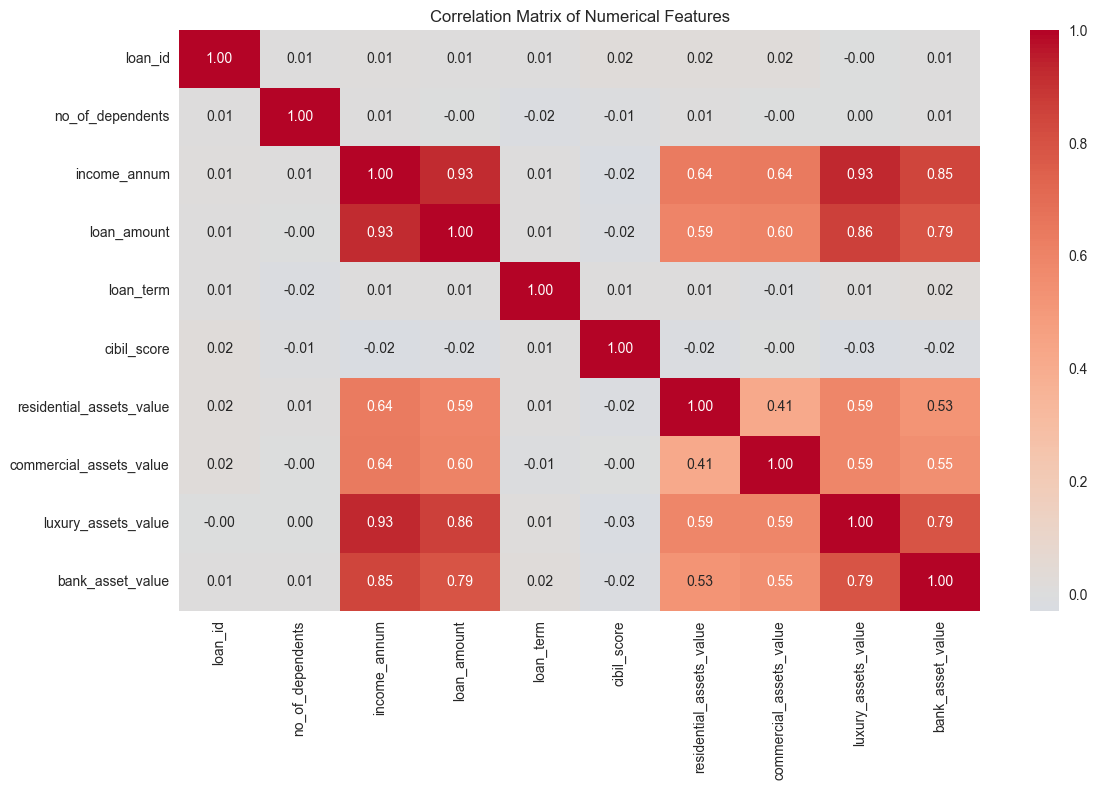

In [7]:
print("\n📊 Statistical Summary:")
print(df.describe())
numerical_cols = df.select_dtypes(include=[np.number]).columns
correlation_matrix = df[numerical_cols].corr()

plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0, fmt='.2f')
plt.title('Correlation Matrix of Numerical Features')
plt.tight_layout()
plt.show()

In [8]:
print("\n3️⃣ DATA PREPROCESSING")
print("-" * 30)
df_processed = df.copy()

# Create new features
print("🔧 Feature Engineering:")
df_processed['loan_to_income_ratio'] = df_processed['loan_amount'] / df_processed['income_annum']
df_processed['total_assets'] = (df_processed['residential_assets_value'] + 
                               df_processed['commercial_assets_value'] + 
                               df_processed['luxury_assets_value'] + 
                               df_processed['bank_asset_value'])
df_processed['asset_to_loan_ratio'] = df_processed['total_assets'] / df_processed['loan_amount']

print("✅ Created new features: loan_to_income_ratio, total_assets, asset_to_loan_ratio")



3️⃣ DATA PREPROCESSING
------------------------------
🔧 Feature Engineering:
✅ Created new features: loan_to_income_ratio, total_assets, asset_to_loan_ratio


In [9]:
categorical_cols = ['education', 'self_employed']
label_encoders = {}

for col in categorical_cols:
    le = LabelEncoder()
    df_processed[col + '_encoded'] = le.fit_transform(df_processed[col])
    label_encoders[col] = le
    print(f"✅ Encoded {col}: {dict(zip(le.classes_, le.transform(le.classes_)))}")

✅ Encoded education: {' Graduate': np.int64(0), ' Not Graduate': np.int64(1)}
✅ Encoded self_employed: {' No': np.int64(0), ' Yes': np.int64(1)}


In [10]:
le_target = LabelEncoder()
df_processed['loan_status_encoded'] = le_target.fit_transform(df_processed['loan_status'])
print(f"✅ Encoded loan_status: {dict(zip(le_target.classes_, le_target.transform(le_target.classes_)))}")

# Select features for modeling
feature_columns = ['no_of_dependents', 'income_annum', 'loan_amount', 'loan_term', 
                  'cibil_score', 'residential_assets_value', 'commercial_assets_value',
                  'luxury_assets_value', 'bank_asset_value', 'education_encoded',
                  'self_employed_encoded', 'loan_to_income_ratio', 'total_assets',
                  'asset_to_loan_ratio']

X = df_processed[feature_columns]
y = df_processed['loan_status_encoded']

print(f"\n📝 Feature matrix shape: {X.shape}")
print(f"📝 Target vector shape: {y.shape}")


✅ Encoded loan_status: {' Approved': np.int64(0), ' Rejected': np.int64(1)}

📝 Feature matrix shape: (4269, 14)
📝 Target vector shape: (4269,)


In [11]:
print("\n4️⃣ MODEL TRAINING AND EVALUATION")
print("-" * 30)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, 
                                                    random_state=42, stratify=y)

print(f"Training set size: {X_train.shape}")
print(f"Test set size: {X_test.shape}")



4️⃣ MODEL TRAINING AND EVALUATION
------------------------------
Training set size: (3415, 14)
Test set size: (854, 14)


In [12]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


In [13]:
def evaluate_model(model, X_train, X_test, y_train, y_test, model_name):
    """Comprehensive model evaluation"""
    print(f"\n🔍 Evaluating {model_name}")
    print("-" * 25)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    y_pred_proba = model.predict_proba(X_test)[:, 1] if hasattr(model, 'predict_proba') else None
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1-Score: {f1:.4f}")
    if y_pred_proba is not None:
        auc_score = roc_auc_score(y_test, y_pred_proba)
        print(f"AUC-ROC: {auc_score:.4f}")
    cv_scores = cross_val_score(model, X_train, y_train, cv=5, scoring='f1')
    print(f"CV F1-Score: {cv_scores.mean():.4f} (+/- {cv_scores.std() * 2:.4f})")
    cm = confusion_matrix(y_test, y_pred)
    print(f"\nConfusion Matrix:")
    print(cm)
    
    return {
        'model': model,
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'auc': auc_score if y_pred_proba is not None else None,
        'predictions': y_pred,
        'probabilities': y_pred_proba
    }

In [14]:
models = {
    'Logistic Regression': LogisticRegression(random_state=42, max_iter=1000),
    'Decision Tree': DecisionTreeClassifier(random_state=42),
    'Random Forest': RandomForestClassifier(random_state=42, n_estimators=100)
}

In [15]:
results = {}
print("🎯 BASELINE MODELS (Without SMOTE)")
print("=" * 40)

for name, model in models.items():
    results[name] = evaluate_model(model, X_train_scaled, X_test_scaled, 
                                  y_train, y_test, name)

🎯 BASELINE MODELS (Without SMOTE)

🔍 Evaluating Logistic Regression
-------------------------
Accuracy: 0.9157
Precision: 0.9088
Recall: 0.8638
F1-Score: 0.8857
AUC-ROC: 0.9745
CV F1-Score: 0.8800 (+/- 0.0246)

Confusion Matrix:
[[503  28]
 [ 44 279]]

🔍 Evaluating Decision Tree
-------------------------
Accuracy: 1.0000
Precision: 1.0000
Recall: 1.0000
F1-Score: 1.0000
AUC-ROC: 1.0000
CV F1-Score: 0.9981 (+/- 0.0049)

Confusion Matrix:
[[531   0]
 [  0 323]]

🔍 Evaluating Random Forest
-------------------------
Accuracy: 1.0000
Precision: 1.0000
Recall: 1.0000
F1-Score: 1.0000
AUC-ROC: 1.0000
CV F1-Score: 0.9973 (+/- 0.0039)

Confusion Matrix:
[[531   0]
 [  0 323]]


In [16]:
print("\n5️⃣ HANDLING CLASS IMBALANCE")
print("-" * 30)
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train_scaled, y_train)

print(f"Original training set distribution: {np.bincount(y_train)}")
print(f"SMOTE training set distribution: {np.bincount(y_train_smote)}")
print("\n🎯 MODELS WITH SMOTE")
print("=" * 25)
results_smote = {}
for name, model in models.items():
    # Create a fresh instance of the model
    if name == 'Logistic Regression':
        fresh_model = LogisticRegression(random_state=42, max_iter=1000)
    elif name == 'Decision Tree':
        fresh_model = DecisionTreeClassifier(random_state=42)
    else:
        fresh_model = RandomForestClassifier(random_state=42, n_estimators=100)
    
    results_smote[name + ' (SMOTE)'] = evaluate_model(fresh_model, X_train_smote, X_test_scaled, 
                                                     y_train_smote, y_test, name + ' (SMOTE)')


5️⃣ HANDLING CLASS IMBALANCE
------------------------------
Original training set distribution: [2125 1290]
SMOTE training set distribution: [2125 2125]

🎯 MODELS WITH SMOTE

🔍 Evaluating Logistic Regression (SMOTE)
-------------------------
Accuracy: 0.9344
Precision: 0.9058
Recall: 0.9226
F1-Score: 0.9141
AUC-ROC: 0.9748
CV F1-Score: 0.9242 (+/- 0.0181)

Confusion Matrix:
[[500  31]
 [ 25 298]]

🔍 Evaluating Decision Tree (SMOTE)
-------------------------
Accuracy: 0.9988
Precision: 0.9969
Recall: 1.0000
F1-Score: 0.9985
AUC-ROC: 0.9991
CV F1-Score: 0.9986 (+/- 0.0018)

Confusion Matrix:
[[530   1]
 [  0 323]]

🔍 Evaluating Random Forest (SMOTE)
-------------------------
Accuracy: 0.9988
Precision: 1.0000
Recall: 0.9969
F1-Score: 0.9984
AUC-ROC: 1.0000
CV F1-Score: 0.9979 (+/- 0.0023)

Confusion Matrix:
[[531   0]
 [  1 322]]


In [17]:
print("\n6️⃣ MODEL COMPARISON")
print("-" * 30)
comparison_data = []
for name, result in {**results, **results_smote}.items():
    comparison_data.append({
        'Model': name,
        'Accuracy': result['accuracy'],
        'Precision': result['precision'],
        'Recall': result['recall'],
        'F1-Score': result['f1'],
        'AUC-ROC': result['auc'] if result['auc'] else 'N/A'
    })

comparison_df = pd.DataFrame(comparison_data)
print("\n📊 Model Comparison:")
print(comparison_df.to_string(index=False, float_format='%.4f'))



6️⃣ MODEL COMPARISON
------------------------------

📊 Model Comparison:
                      Model  Accuracy  Precision  Recall  F1-Score  AUC-ROC
        Logistic Regression    0.9157     0.9088  0.8638    0.8857   0.9745
              Decision Tree    1.0000     1.0000  1.0000    1.0000   1.0000
              Random Forest    1.0000     1.0000  1.0000    1.0000   1.0000
Logistic Regression (SMOTE)    0.9344     0.9058  0.9226    0.9141   0.9748
      Decision Tree (SMOTE)    0.9988     0.9969  1.0000    0.9985   0.9991
      Random Forest (SMOTE)    0.9988     1.0000  0.9969    0.9984   1.0000


In [18]:
best_model_name = max(results_smote.keys(), key=lambda x: results_smote[x]['f1'])
best_model = results_smote[best_model_name]['model']

print(f"\n🏆 Best Model: {best_model_name}")
print(f"   F1-Score: {results_smote[best_model_name]['f1']:.4f}")


🏆 Best Model: Decision Tree (SMOTE)
   F1-Score: 0.9985


In [19]:
print("\n7️⃣ HYPERPARAMETER TUNING")
print("-" * 30)

if 'Logistic Regression' in best_model_name:
    param_grid = {
        'C': [0.1, 1, 10, 100],
        'penalty': ['l1', 'l2'],
        'solver': ['liblinear', 'saga']
    }
    base_model = LogisticRegression(random_state=42, max_iter=1000)
elif 'Decision Tree' in best_model_name:
    param_grid = {
        'max_depth': [3, 5, 7, 10, None],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4]
    }
    base_model = DecisionTreeClassifier(random_state=42)
else:
    param_grid = {
        'n_estimators': [50, 100, 200],
        'max_depth': [3, 5, 7, None],
        'min_samples_split': [2, 5, 10]
    }
    base_model = RandomForestClassifier(random_state=42)



7️⃣ HYPERPARAMETER TUNING
------------------------------


In [20]:
grid_search = GridSearchCV(base_model, param_grid, cv=5, scoring='f1', n_jobs=-1)
grid_search.fit(X_train_smote, y_train_smote)

print(f"🔧 Best parameters: {grid_search.best_params_}")
print(f"🔧 Best CV F1-score: {grid_search.best_score_:.4f}")
final_model = grid_search.best_estimator_
final_results = evaluate_model(final_model, X_train_smote, X_test_scaled, 
                              y_train_smote, y_test, "Final Tuned Model")

🔧 Best parameters: {'max_depth': 5, 'min_samples_leaf': 1, 'min_samples_split': 10}
🔧 Best CV F1-score: 0.9991

🔍 Evaluating Final Tuned Model
-------------------------
Accuracy: 0.9988
Precision: 0.9969
Recall: 1.0000
F1-Score: 0.9985
AUC-ROC: 0.9991
CV F1-Score: 0.9991 (+/- 0.0018)

Confusion Matrix:
[[530   1]
 [  0 323]]



8️⃣ FEATURE IMPORTANCE
------------------------------
📈 Feature Importance:
                 Feature  Importance
             cibil_score      0.8509
    loan_to_income_ratio      0.0768
               loan_term      0.0563
     asset_to_loan_ratio      0.0150
 commercial_assets_value      0.0009
            income_annum      0.0000
residential_assets_value      0.0000
             loan_amount      0.0000
        no_of_dependents      0.0000
     luxury_assets_value      0.0000
       education_encoded      0.0000
        bank_asset_value      0.0000
   self_employed_encoded      0.0000
            total_assets      0.0000


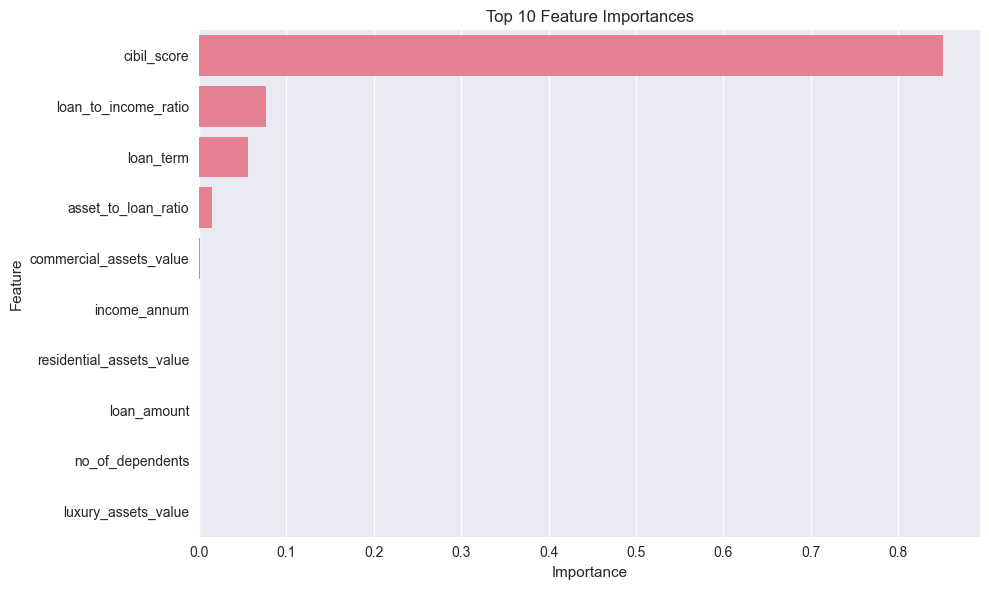

In [21]:
print("\n8️⃣ FEATURE IMPORTANCE")
print("-" * 30)

if hasattr(final_model, 'feature_importances_'):
    importance_df = pd.DataFrame({
        'Feature': feature_columns,
        'Importance': final_model.feature_importances_
    }).sort_values('Importance', ascending=False)
    
    print("📈 Feature Importance:")
    print(importance_df.to_string(index=False, float_format='%.4f'))
    plt.figure(figsize=(10, 6))
    sns.barplot(data=importance_df.head(10), x='Importance', y='Feature')
    plt.title('Top 10 Feature Importances')
    plt.tight_layout()
    plt.show()
elif hasattr(final_model, 'coef_'):
    importance_df = pd.DataFrame({
        'Feature': feature_columns,
        'Coefficient': abs(final_model.coef_[0])
    }).sort_values('Coefficient', ascending=False)
    
    print("📈 Feature Coefficients (Absolute):")
    print(importance_df.to_string(index=False, float_format='%.4f'))


9️⃣ ROC CURVE ANALYSIS
------------------------------


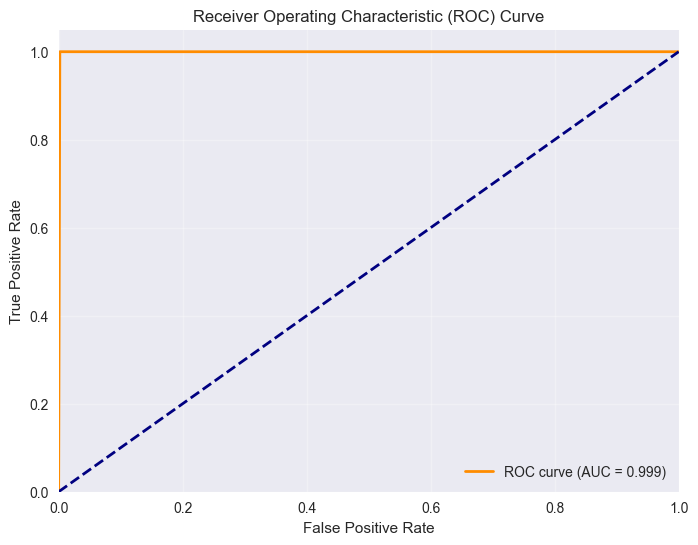

In [22]:
print("\n9️⃣ ROC CURVE ANALYSIS")
print("-" * 30)
if hasattr(final_model, 'predict_proba'):
    y_pred_proba = final_model.predict_proba(X_test_scaled)[:, 1]
    fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
    auc_score = roc_auc_score(y_test, y_pred_proba)
    
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {auc_score:.3f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc="lower right")
    plt.grid(alpha=0.3)
    plt.show()

In [23]:
print("\n🔟 SAVING MODEL AND PREPROCESSORS")
print("-" * 30)
joblib.dump(final_model, 'loan_approval_model.pkl')
joblib.dump(scaler, 'loan_scaler.pkl')
joblib.dump(label_encoders, 'label_encoders.pkl')
joblib.dump(le_target, 'target_encoder.pkl')
joblib.dump(feature_columns, 'feature_columns.pkl')

print("✅ Model saved as 'loan_approval_model.pkl'")
print("✅ Scaler saved as 'loan_scaler.pkl'")
print("✅ Label encoders saved as 'label_encoders.pkl'")
print("✅ Target encoder saved as 'target_encoder.pkl'")
print("✅ Feature columns saved as 'feature_columns.pkl'")


🔟 SAVING MODEL AND PREPROCESSORS
------------------------------
✅ Model saved as 'loan_approval_model.pkl'
✅ Scaler saved as 'loan_scaler.pkl'
✅ Label encoders saved as 'label_encoders.pkl'
✅ Target encoder saved as 'target_encoder.pkl'
✅ Feature columns saved as 'feature_columns.pkl'
